<a href="https://colab.research.google.com/github/anosharahim/deep-learning/blob/master/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview 

Transfer Learning using Resnet50 on the FER2013 dataset. 



In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


## Import relevant packages and libraries


In [2]:
#for preprocessing
import pandas as pd
import os
import imageio
import numpy as np

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

#machine learning specific 
import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

## Data Preprocessing 

In [7]:
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

train_data = []
train_label = []
test_data = []
test_label = []

num_expressions = 6

#keep track of y labels 
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_image_arrays(folder_path, label_dict):
  data = []
  label = []
  freq = {}

  for category in os.listdir(folder_path): 

    category_name = label_dict[category]
    category_path = folder_path + category + '/'
    freq[category] = 0

    for image in os.listdir(category_path):
      image_file = category_path + image 
      image_array = imageio.imread(image_file) #get image array from file 
      #image_array.resize((32, 32))
      image_array = np.array(image_array) #convert to numpy array 
      #add image array and it's label to respective folders 
      data.append(image_array)
      label.append(category_name)
      freq[category] += 1

  data = np.array(data)
  label = np.array(label)

  data, label = unison_shuffled_copies(data, label)

  return data, label, freq

train_data, train_label, train_freq = get_image_arrays(train_path, emotion_dictionary)
test_data, test_label, test_freq = get_image_arrays(test_path, emotion_dictionary)

In [8]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(28709, 48, 48) (28709,)
(7178, 48, 48) (7178,)


In [11]:
#add 2 more channels to grayscale image to imitate rgb
X_train = np.repeat(train_data[..., np.newaxis], 3, -1)
x_test = np.repeat(test_data[..., np.newaxis], 3, -1)

y_train, y_test = train_label, test_label
X_val, X_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.3)

X_train = np.resize(X_train, (len(X_train), 32, 32,3))
X_val = np.resize(X_val, (len(X_val), 32, 32,3))
X_test = np.resize(X_test, (len(X_test), 32, 32,3))

print('Train -- ', X_train.shape, y_train.shape)
print('Val -- ', X_val.shape, y_val.shape)
print('Test -- ', X_test.shape, y_test.shape)


Train --  (28709, 32, 32, 3) (28709,)
Val --  (5024, 32, 32, 3) (5024,)
Test --  (2154, 32, 32, 3) (2154,)


<BarContainer object of 7 artists>

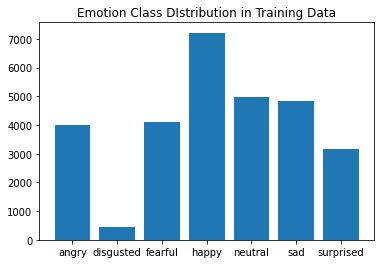

In [12]:
plt.title("Emotion Class DIstribution in Training Data")
plt.bar(list(train_freq.keys()),list(train_freq.values()))

In [13]:
#oversampling minority classes to deal with class imbalance
#oversampler = RandomOverSampler(sampling_strategy='minority')
#y = train_data.reshape(len(train_data), 48*48)
#train_data, train_label = oversampler.fit_resample(T, train_label)

#u, c = np.unique(train_label, return_counts=True)
#plt.bar(u,c)

#Tt = train_data.reshape(len(train_data),48,48)


## Compile the ResNet50 Model 

In [14]:
input_t = K.Input(shape=(32,32,3))
res50_model = K.applications.ResNet50(include_top=False, weights="imagenet",input_tensor=input_t)

#freeze the first n layers 
freeze_layers = 160
#only train last 30 layers 
for layer in res50_model.layers[:freeze_layers]:
  layer.trainable =False

#verify that the desired layers are frozen 
for i, layer in enumerate(res50_model.layers):
  if i == 10:
    print("...")
  if i < 10 or i > (freeze_layers - 3):  
    print(i,layer.name,'-',layer.trainable)

#add further layers 
model = K.models.Sequential()
model.add(res50_model)
model.add(K.layers.Dropout(0.2))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(10, activation='softmax'))

'''
model.add(res50_model)
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dense(7,activation='softmax'))
-----

model.add(res50_model)
#model.add(K.layers.BatchNormalization())
#model.add(K.layers.GlobalAveragePooling2D())
model.add(K.layers.Flatten()) 
model.add(K.layers.Dropout(0.6)) #to avoid overfitting 
model.add(K.layers.Dense(10, activation='softmax'))
'''

#Compile the model 
#since y labels are integers, use sparse categorical cross-entropy 
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=K.optimizers.Adam(learning_rate=2e-5),#Adam(learning_rate=2e-5),
                  metrics=['accuracy'])

model.summary()

0 input_2 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
...
158 conv5_block2_2_conv - False
159 conv5_block2_2_bn - False
160 conv5_block2_2_relu - True
161 conv5_block2_3_conv - True
162 conv5_block2_3_bn - True
163 conv5_block2_add - True
164 conv5_block2_out - True
165 conv5_block3_1_conv - True
166 conv5_block3_1_bn - True
167 conv5_block3_1_relu - True
168 conv5_block3_2_conv - True
169 conv5_block3_2_bn - True
170 conv5_block3_2_relu - True
171 conv5_block3_3_conv - True
172 conv5_block3_3_bn - True
173 conv5_block3_add - True
174 conv5_block3_out - True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                         

## Model Training

In [15]:
ckpt_path = os.path.join('/gdrive', 'ckpt', 'fer_2013') 

#create model checkpoint to save weights
check_point = K.callbacks.ModelCheckpoint(filepath=  ckpt_path,
                                              monitor="val_accuracy",
                                              mode="max",
                                              save_best_only=True,)

#Train the model 
history = model.fit(X_train, y_train, batch_size=512,  epochs=5, verbose=1, #batch_size=512,
                        validation_data=(X_val, y_val),
                        callbacks=[check_point])

model.save(ckpt_path) 

Epoch 1/5
57/57 [==============================] - ETA: 0s - loss: 3.6284 - accuracy: 0.1504

FailedPreconditionError: ignored

## Results and Interpretation 